# Connect to the drive repository

In [78]:
## mount to the drive
import os 
import sys 
import time
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [81]:
%cd drive/MyDrive/NLP_PRO_ENSAE

/content/drive/.shortcut-targets-by-id/1IqM7cDbYq5buCZ4NGtd30LjG6kK7AEx7/NLP_PRO_ENSAE


In [82]:
%ls

 analyst_tone/            'FinBert Model Example.ipynb'
'bertModel (1).py'         GoogleNews-vectors-negative300.zip
'bertModel (2).py'         kaggle.json
'bertModel (3).py'         nilm_metadata-master/
 bertModel.py              nilmtk-master/
 best_model_state1.bin     pretrained-models/
 best_model_state.bin      __pycache__/
 best_model_state_ro.bin   Reviews.csv
 character-bert/          'test finBURT (final).ipynb'
 df_test.csv               train_bert.py
 df_train.csv              Untitled0.ipynb
 df_val.csv


# Useful libraries

In [83]:
%cd nilm_metadata-master
!python setup.py develop
%cd ..
!sudo apt-get install postgresql postgresql-contrib
!sudo apt-get install postgresql-server-dev-all
!pip install psycopg2
!pip install nose coveralls coverage
%cd nilmtk-master
!python setup.py develop

/content/drive/.shortcut-targets-by-id/1IqM7cDbYq5buCZ4NGtd30LjG6kK7AEx7/NLP_PRO_ENSAE/nilm_metadata-master
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
running develop
running egg_info
creating nilm_metadata.egg-info
writing nilm_metadata.egg-info/PKG-INFO
writing dependency_links to nilm_metadata.egg-info/dependency_links.txt
writing requirements to nilm_metadata.egg-info/requires.txt
writing top-level names to nilm_metadata.egg-info/top_level.txt
writing manifest file 'nilm_metadata.egg-info/SOURCES.txt'
reading manifest file 'nilm_metadata.egg-info/SOURCES.txt'
writing manifest file 'nilm_metadata.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/nilm-metadata.egg-link (link to .)
Adding nilm-metadata 0.2.5 to easy-install.pth file

Installed /content/drive/.shortcut-targets-by-id/1IqM7cDbYq5buCZ4NGtd30LjG6kK7AEx7/NLP_PRO_ENSAE/nilm_metadata-mas

In [85]:
!pip install transformers==3.3.1

In [4]:
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-tp_exzu8
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-tp_exzu8
  Created wheel for nlpaug: filename=nlpaug-1.1.3-cp37-none-any.whl size=837272 sha256=addb930f1caed0cfd798a34589e0c389210629e8529192b33372b398cc86623c
  Stored in directory: /tmp/pip-ephem-wheel-cache-oauvlbzz/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


In [87]:
!pip install nltk
!pip install datasets

In [92]:
import nltk
nltk.download('text_dataset')

[nltk_data] Error loading text_dataset: Package 'text_dataset' not
[nltk_data]     found in index


False

In [41]:
!pip install urllib3
!pip install pytorch_pretrained_bert

In [61]:
#!git clone https://github.com/helboukkouri/character-bert.git
!pip install datasets
!pip install tf-nightly

     |████████████████████████████████| 457.2MB 39kB/s 
     |████████████████████████████████| 471kB 57.0MB/s 
     |████████████████████████████████| 4.2MB 50.2MB/s 
     |████████████████████████████████| 4.0MB 46.4MB/s 
     |████████████████████████████████| 6.1MB 47.3MB/s 
     |████████████████████████████████| 1.3MB 52.6MB/s 
     |████████████████████████████████| 3.9MB 46.4MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.37.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: h5py 2.10.0
    Uninstalli

In [93]:

from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time



#import torch.nn as nn
#from torch.utils.data import Dataset
#from transformers import BertTokenizer, AutoModel, AutoTokenizer
#from torch.utils.data import DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertConfig, BertForSequenceClassification, RobertaModel, RobertaTokenizer
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm
from random import shuffle
import random
import nlpaug.augmenter.word as naw

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
#from datasets import text_dataset, financialPhraseBankDataset

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

# Dataset part

## Data exploration

In [8]:
## import the first dataframe (amazon-fine-food-review)
df = pd.read_csv('Reviews.csv')
print(df.shape)
df.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


There are no missing values in score and reviews. So we check whether class are unbalanced or not.

It's common that users duplicate theirs comments and score to avoid loss time. So we will check if that's the case in this dataset and just keep the first comment among duplicates comments.

In [10]:
df_final=df.drop_duplicates(subset=['UserId','ProfileName','Score','Time','Summary','Text'],keep='first')
print(df_final.shape)
print(df.shape)

(395200, 10)
(568454, 10)


Its common that HelpfulnessNumerator (Number of users who found the review helpful) can not be greater than HelpfulnessDenominator(Number of users who indicated whether they found the review helpful or not) So we will only keep rows that respect this condition.

In [11]:
df_final=df_final[df_final['HelpfulnessNumerator']<=df_final['HelpfulnessDenominator']]
print(df_final.shape)


(395198, 10)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


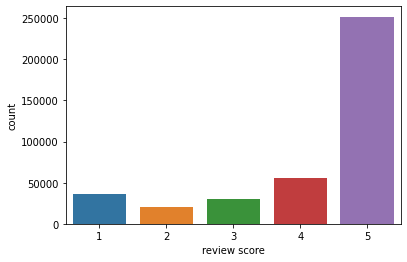

In [12]:
sns.countplot(df_final.Score)
plt.xlabel('review score');

Classes are unbalanced we will try to fix this issue next. We are only interested in comments and the rank of product so we will only keep two columns of the dataset (score and Text). We make an assumption "the higher the rank, the better the reviews". The rank is between 1 and 5 so We're going to convert the dataset into negative, neutral and positive sentiment: 
- 0 if the rank is between 1 and 2 (negative);
- 1 if the rank is egual to 3 (neural);
- 2 if the rank is high than 3 (positive).


 

In [13]:
df_final['sentiment'] = [2 if j>3 else 1 if j==3 else 0 for j in df_final['Score']]


In [14]:
print(df_final.shape)
df_final.head()

(395198, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2


In [15]:
##keeping the two columns of interest
data = df_final[['sentiment','Text']]
data.head()

,sentiment,Text
0,2,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,2,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,2,Great taffy at a great price. There was a wid...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


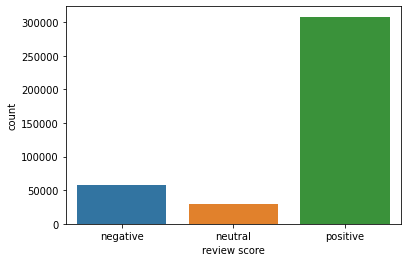

In [16]:
## visualisation of the distribution of the sentiment
class_names = ['negative', 'neutral', 'positive']
ax=sns.countplot(data.sentiment)
plt.xlabel('review score')
ax.set_xticklabels(class_names);

## Data augmentation
In the last section we check that classes are unbalanced so in this section we will fix this issue by performing data augmentation. The data augmentation involve in these techniques:
- Synonym replacement (SR) Synonym replacement is a technique in which we replace a word by one of its synonyms. 
- Random Deletion (RD) In Random Deletion, we randomly delete a word if a uniformly generated number between 0 and 1 is smaller than a pre-defined threshold. 
- Random Swap (RS) In Random Swap, we randomly swap the order of two words in a sentence.
- Random Insertion (RI) Finally, in Random Insertion, we randomly insert synonyms of a word at a random position.

These techniques are presented in this [paper](https://arxiv.org/pdf/1901.11196.pdf)

In [ ]:
##split data on train, evaluation, test sets
df_train, df_test = train_test_split(df_final, test_size=0.25, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

In [ ]:
##keeping the two columns of interest
data = df_train[['sentiment','Text']]
data.head()

In [ ]:
## visualisation of the distribution of the sentiment
class_names = ['negative', 'neutral', 'positive']
ax=sns.countplot(data.sentiment)
plt.xlabel('review score')
ax.set_xticklabels(class_names);

In [ ]:
aug = naw.ContextualWordEmbsAug(model_path='bert-base-cased') # word will be replaced according to contextual embeddings calculation
aug_w2v = naw.ContextualWordEmbsAug(model_path='bert-base-cased',
                                    action="insert") #a new word will be injected to random position according to contextual word embeddings calculation

In [ ]:
def augment_text(df,samples=300,pr=0.2,classes=1):
    aug_w2v.aug_p=pr
    aug.aug_p=pr
    new_text=[]
    

    ##selecting the class samples
    df_n=df[df.sentiment==classes].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
            #p = random.random()
            #if p<0.5:
            text = df_n.iloc[i]['Text']
            augmented_text = aug_w2v.augment(text)
            new_text.append(augmented_text)
          #else:
            text1 = df_n.iloc[i]['Text']
            augmented_text = aug.augment(text1)
            new_text.append(augmented_text)
    
    ## dataframe
    new=pd.DataFrame({'Text':new_text,'sentiment':classes})
    #df=shuffle(df.append(new).reset_index(drop=True))
    return new #df

In [ ]:
##augmentation for the neutral class
#%%time
n_neutral = np.sum(df_train.sentiment==1)
tmp1 = augment_text(data,1000 )

In [ ]:
##augmentation for the negative class
#n_neg = np.sum(df_train.sentiment==0)
tmp2 = augment_text(data,1000,classes=0 )

In [ ]:
data_train.head()

In [ ]:
text=data.append(tmp1).reset_index(drop=True)
data_train=text.append(tmp2).reset_index(drop=True)

In [ ]:
print(data_train.shape)
print(data.shape)

In [ ]:
data_train.to_csv("df_train.csv")
df_test.to_csv("df_test.csv")
df_val.to_csv("df_val.csv")

In [ ]:
##read data
df_train = pd.read_csv('df_train.csv',index_col=0)
df_test = pd.read_csv('df_test.csv', index_col=0)
df_val = pd.read_csv('df_val.csv', index_col=0)

# Read train, test and evaluation dataset

In [17]:
##read data
df_train = pd.read_csv('df_train.csv',index_col=0)
df_test = pd.read_csv('df_test.csv')
df_val = pd.read_csv('df_val.csv')

# Sentiment analysis with BERT

## Data prepocessing

Machine don't really understand the raw text so we have to convert it into number to be comprehensible by the machine. In the case of BERT we have three principal obligations (read more [here](https://github.com/google-research/bert)):

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

This can be done by using the BertTokenizer of tranformers class. For this task we will use the **BERT base cased model** because we matter about accent and case (it is usefull to understand the review).

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
## load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We have to define the maximum lenght that will be considered in each review. So we will plot the distribution of tokens in the dataset for each review.

In [ ]:
token_lens = []

for txt in df_final.Text:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


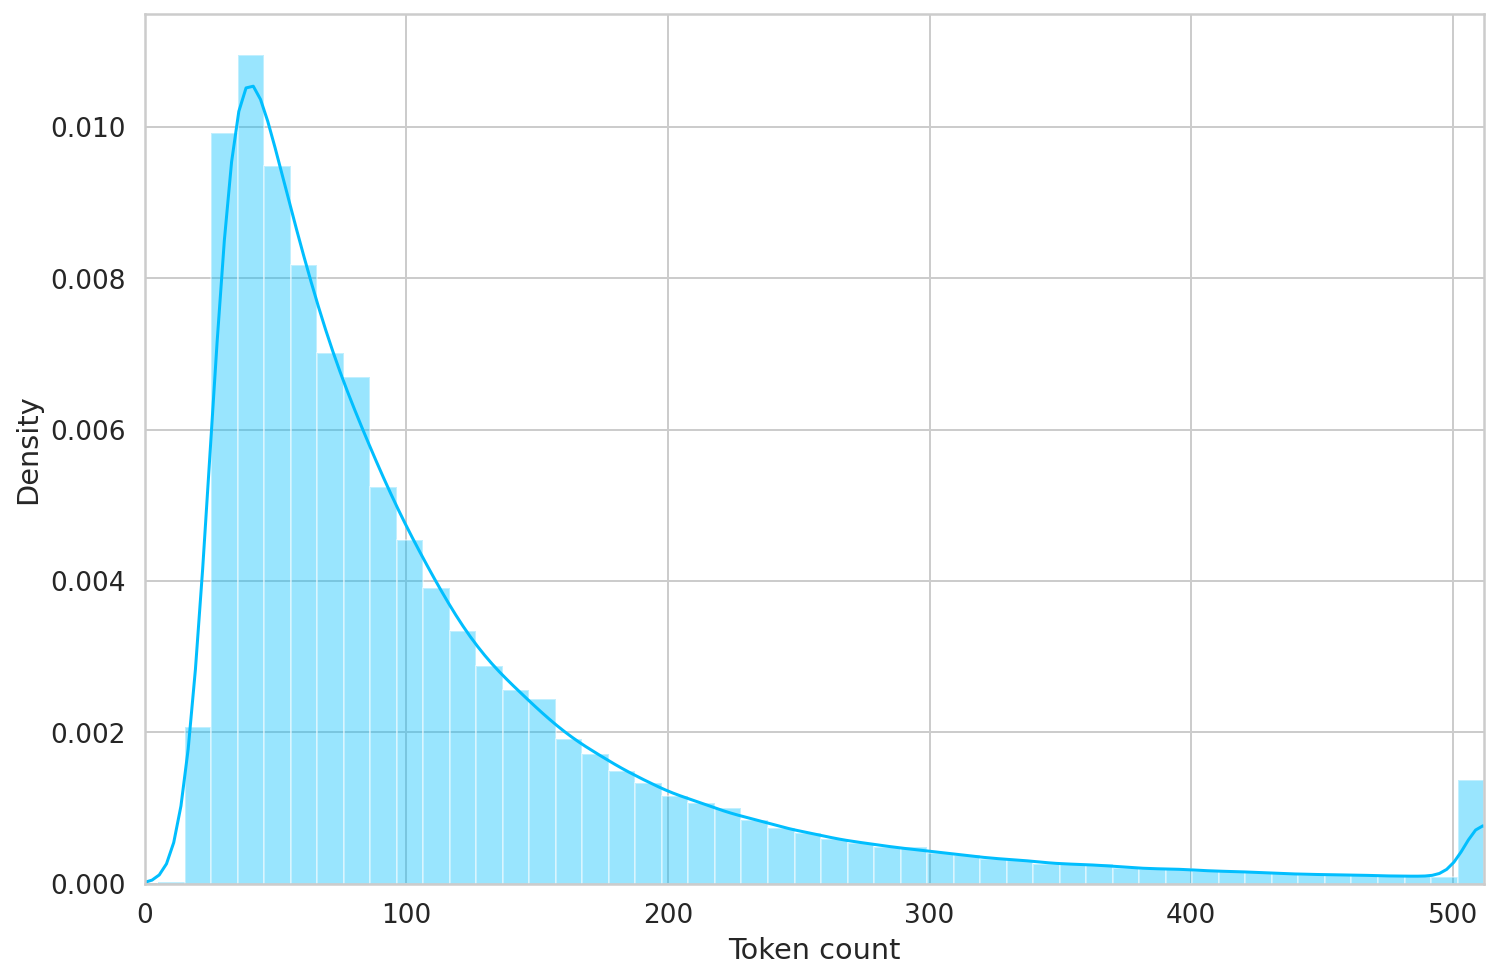

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

We will take the maximum length equal to 200 due to computationnal ressources.

In [ ]:
MAX_LEN = 200

In [ ]:
class Data(Dataset):

  def __init__(self, reviews, targets, tokenizer=tokenizer, max_len=MAX_LEN):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def load_batch(df, batch_size=32,max_len=MAX_LEN, tokenizer = tokenizer):
  tmp = Data(df.Text.to_numpy(), 
             df.sentiment.to_numpy(), 
             tokenizer, 
             max_len)
  return DataLoader(tmp,  batch_size=batch_size, shuffle= True)

In [ ]:
BATCH_SIZE = 32

train_data_loader = load_batch(df_train)
val_data_loader = load_batch(df_val)
test_data_loader = load_batch(df_test)

## BERT Model
In this section we will perform a sentiment analysis with BERT base cased pretrained model.

The bert_model have two outputs: last_hidden_state, pooled_output. So for this task we will only keep the pooled_output and add a dense layer in the top of the class.

In [ ]:
## This is the pytorch class for the BERT sentiment analysis
class sentiment_analysis(nn.Module):
  def __init__(self, n_classes):
    super(sentiment_analysis, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    tmp = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = tmp[1]
    output = self.drop(pooled_output)
    #output = self.out(output)
    return self.out(output) #F.softmax(output, dim=1)

In [ ]:
n_classes=3

In [ ]:
model = sentiment_analysis(n_classes)
model = model.to(device)

## Training

In [ ]:
# We set the number of epochs, the optimzer, the loss and the scheduler
class_weights = torch.tensor([np.sum(df_train['sentiment']==0)/len(df_train), np.sum(df_train['sentiment']==1)/len(df_train), np.sum(df_train['sentiment']==2)/len(df_train)])
EPOCHS = 5
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters() , lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.float()).to(device)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
## the training function
def train(model,
          data_loader, 
          n_examples,
          device = device,
          optimizer= optimizer, 
          loss=loss_fn,
          scheduler = scheduler):
  model.train()
  losses=[]
  correct_predictions=0
  for data in data_loader:

    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)

    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())
    correct_predictions += torch.sum(preds == targets)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)



In [ ]:
## the evaluation function



def eval(model,
          data_loader, 
          n_examples,
          device = device
         ):
  model.eval()
  losses=[]
  correct_predictions=0
  with torch.no_grad():
    for data in data_loader:

      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      targets = data['targets'].to(device)

      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())
      correct_predictions += torch.sum(preds == targets)
      
      
  return correct_predictions.double() / n_examples, np.mean(losses)



With previous function we are now able to train the model

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'epoch{epoch + 1}/{EPOCHS}')
  print('-'*20)

  train_acc, train_loss = train(model, train_data_loader, len(df_train))
  print(f'train accuracy {train_acc} train loss {train_loss}')

  val_acc, val_loss = eval(model, val_data_loader, len(df_val)) 
  print(f'validation accuracy {val_acc} validation loss {val
                                                         _loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)



  
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

epoch1/5
--------------------
train accuracy 0.9320440758709573 train loss 0.04430340707138738
validation accuracy 0.906255060728745 validation loss 0.10394163160078038
epoch2/5
--------------------
train accuracy 0.939854519936032 train loss 0.035146392867065425
validation accuracy 0.906255060728745 validation loss 0.10388645113309648
epoch3/5
--------------------
train accuracy 0.9402357640739816 train loss 0.03520376744795881
validation accuracy 0.906255060728745 validation loss 0.10396259819412872
epoch4/5
--------------------
train accuracy 0.9400974365549025 train loss 0.035151728486045926
validation accuracy 0.906255060728745 validation loss 0.10393142052672784
epoch5/5
--------------------
train accuracy 0.939992847455111 train loss 0.03537994669960843
validation accuracy 0.906255060728745 validation loss 0.10392577352852457
CPU times: user 3h 23min 30s, sys: 2h 3min 11s, total: 5h 26min 42s
Wall time: 5h 26min


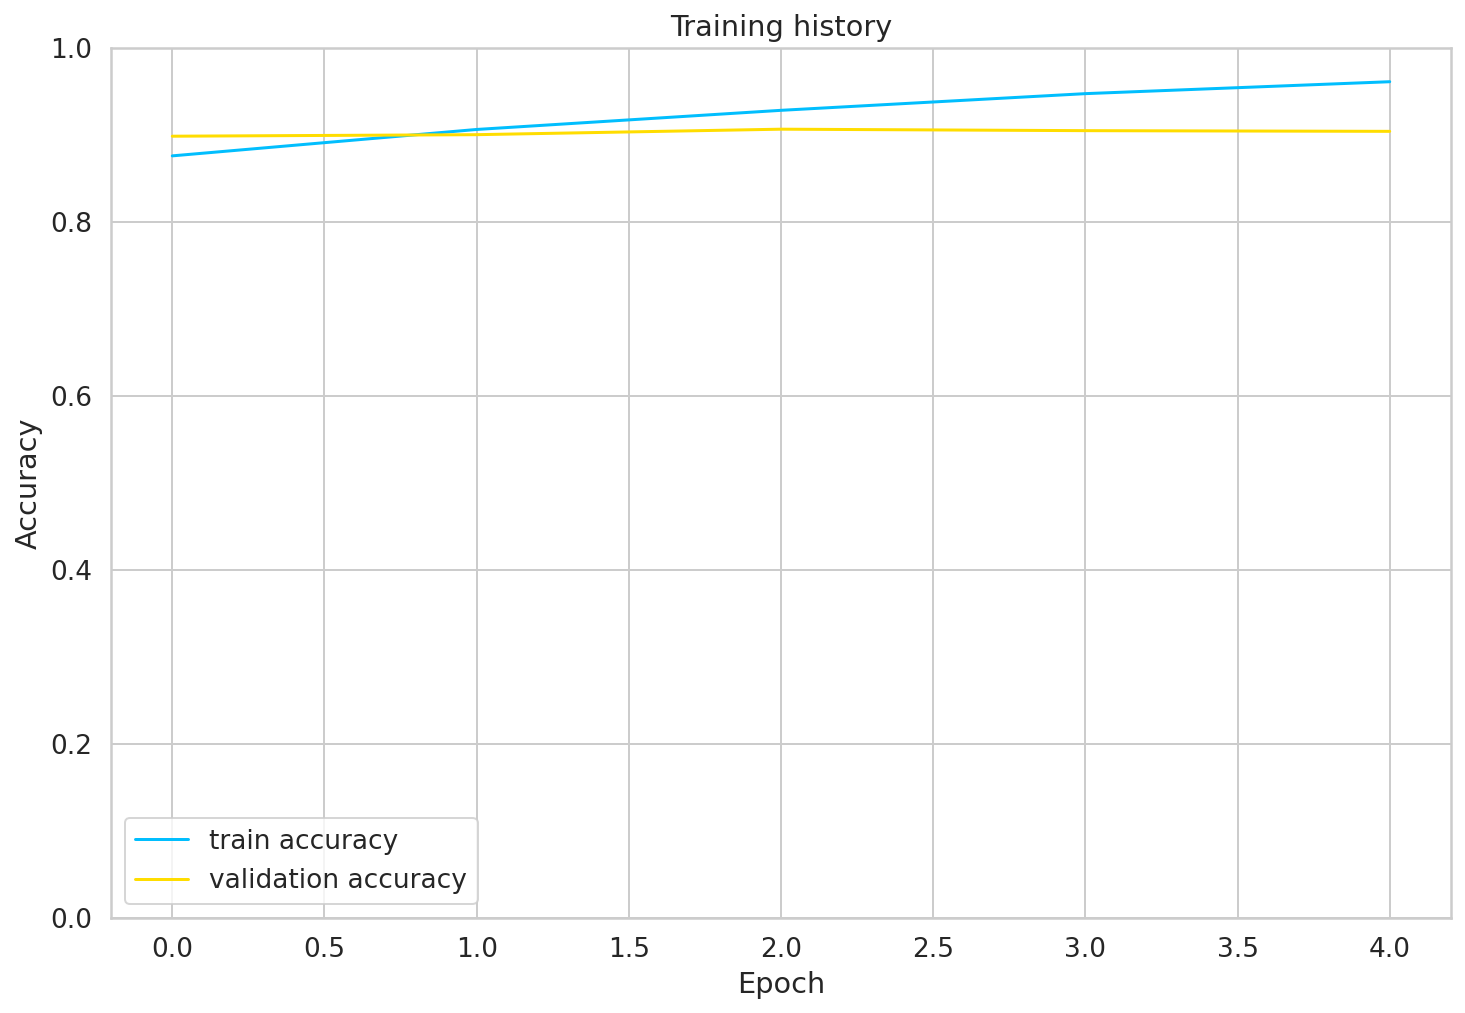

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

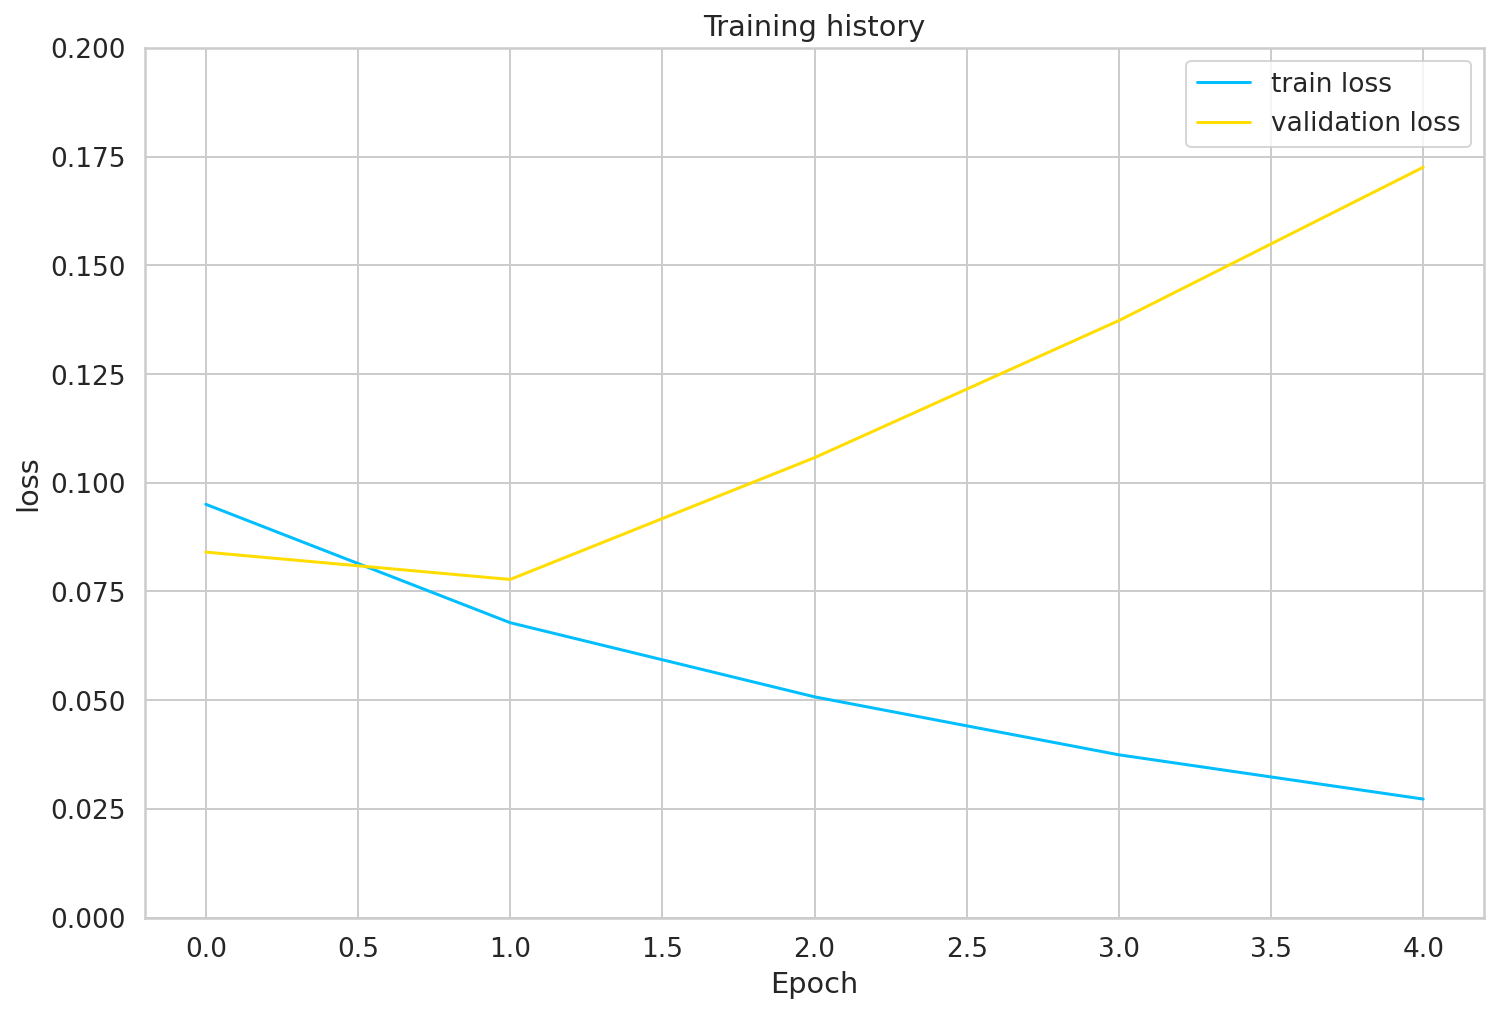

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.2]);

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'epoch{epoch + 1}/{EPOCHS}')
  print('-'*20)

  train_acc, train_loss = train(model, train_data_loader, len(df_train))
  print(f'train accuracy {train_acc} train loss {train_loss}')

  val_acc, val_loss = eval(model, val_data_loader, len(df_val)) 
  print(f'validation accuracy {val_acc} validation loss {val_loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)



  
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state1.bin')
    best_accuracy = val_acc

epoch1/5
--------------------
train accuracy 0.875794778926624 train loss 0.09504186452702612
validation accuracy 0.8984008097165992 validation loss 0.08404562994671884
epoch2/5
--------------------
train accuracy 0.9061545016944188 train loss 0.06781365607568685
validation accuracy 0.900161943319838 validation loss 0.07775477114411908
epoch3/5
--------------------
train accuracy 0.9281619717840998 train loss 0.05076573170528779
validation accuracy 0.9064777327935223 validation loss 0.10575387858024314
epoch4/5
--------------------
train accuracy 0.9473332046152105 train loss 0.03743331457699815
validation accuracy 0.9047773279352227 validation loss 0.13728369930379064
epoch5/5
--------------------
train accuracy 0.9610483425322406 train loss 0.02725639611982147
validation accuracy 0.9039878542510121 validation loss 0.17253982727256015
CPU times: user 5h 27min 51s, sys: 3h 22min 53s, total: 8h 50min 45s
Wall time: 8h 49min 11s


# Sentiment analysis with Roberta


## preparing dataloader

In [109]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [108]:
MAX_LEN=200

In [110]:
class Roberta_Data(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=200):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Text
        self.targets = self.data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            truncation=True,
            padding='max_length',
            #strategy = 'truncation',
            add_special_tokens=True,
            max_length=self.max_len,
            #pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'text': text,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [111]:

def load_batch2(df, batch_size=32,max_len=MAX_LEN, tokenizer = tokenizer):
  tmp = Roberta_Data(df, 
             tokenizer, 
             max_len)
  return DataLoader(tmp,  batch_size=batch_size, shuffle= True)

In [112]:
BATCH_SIZE = 32

train_data_loader = load_batch2(df_train)
#val_data = df_val[['sentiment','Text']]
val_data_loader = load_batch2(df_val)
#test_data = df_test[['sentiment','Text']]
test_data_loader = load_batch2(df_test)

##Roberta model

In [113]:
class RobertaClass(torch.nn.Module):
    def __init__(self,n_classes=3):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [114]:
model = RobertaClass()
model = model.to(device)

## training

In [115]:
# We set the number of epochs, the optimzer, the loss and the scheduler
class_weights = torch.tensor([np.sum(df_train['sentiment']==0)/len(df_train), np.sum(df_train['sentiment']==1)/len(df_train), np.sum(df_train['sentiment']==2)/len(df_train)])
EPOCHS = 5
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters() , lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.float()).to(device)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_ro(model,
          dataloader=train_data_loader,
          n_examples=df_train.shape[0], 
          device = device,
          optimizer= optimizer, 
          loss=loss_fn,
          scheduler = scheduler):
    losses = []
    n_correct = 0
    #nb_tr_steps = 0
    #nb_tr_examples = 0
    model.train()
    for _,data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        tr_loss = loss(outputs, targets)
        losses.append(tr_loss.item())
        _, preds = torch.max(outputs.data, dim=1)
        n_correct += (preds==targets).sum()

        optimizer.zero_grad()
        tr_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return n_correct.double() / n_examples, np.mean(losses)

In [117]:

## the evaluation function

def eval_ro(model,
          dataloader=val_data_loader, 
          n_examples= df_val.shape[0],
          loss=loss_fn,
          device = device
         ):
  model.eval()
  losses=[]
  n_correct=0
  with torch.no_grad():
    for _,data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        tr_loss = loss(outputs, targets)
        losses.append(tr_loss.item())
        _, preds = torch.max(outputs.data, dim=1)
        n_correct += (preds==targets).sum()

    return n_correct.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'epoch{epoch + 1}/{EPOCHS}')
  print('-'*20)

  train_acc, train_loss = train_ro(model)
  print(f'train accuracy {train_acc} train loss {train_loss}')

  val_acc, val_loss = eval_ro(model) 
  print(f'validation accuracy {val_acc} validation loss {val_loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_ro.bin')
    best_accuracy = val_acc

epoch1/5
--------------------


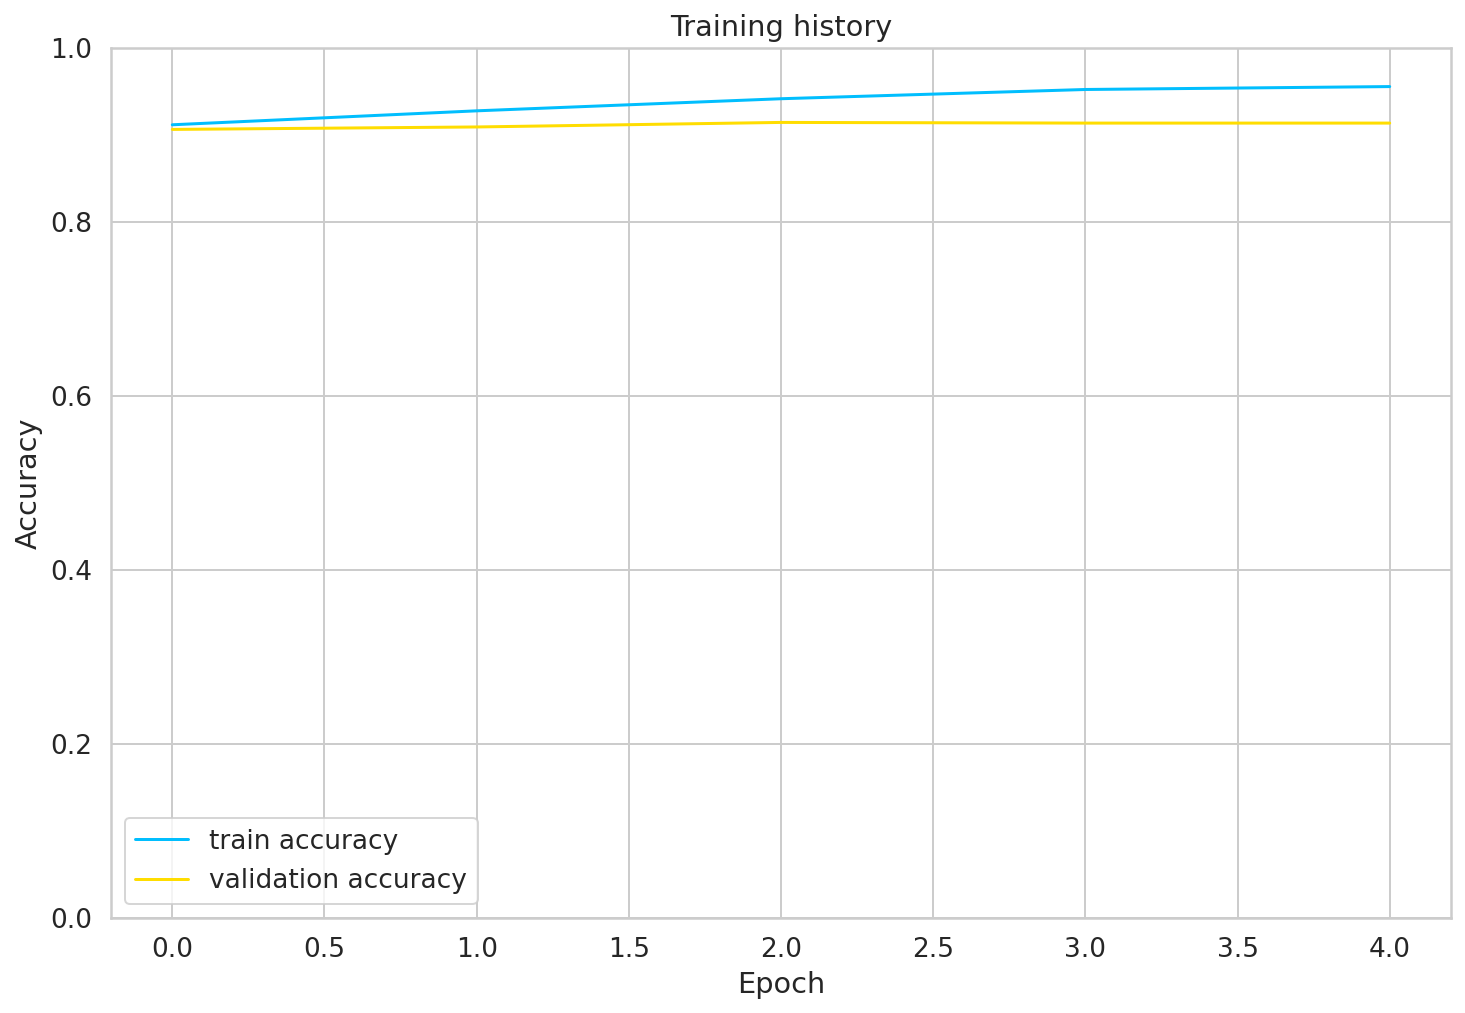

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

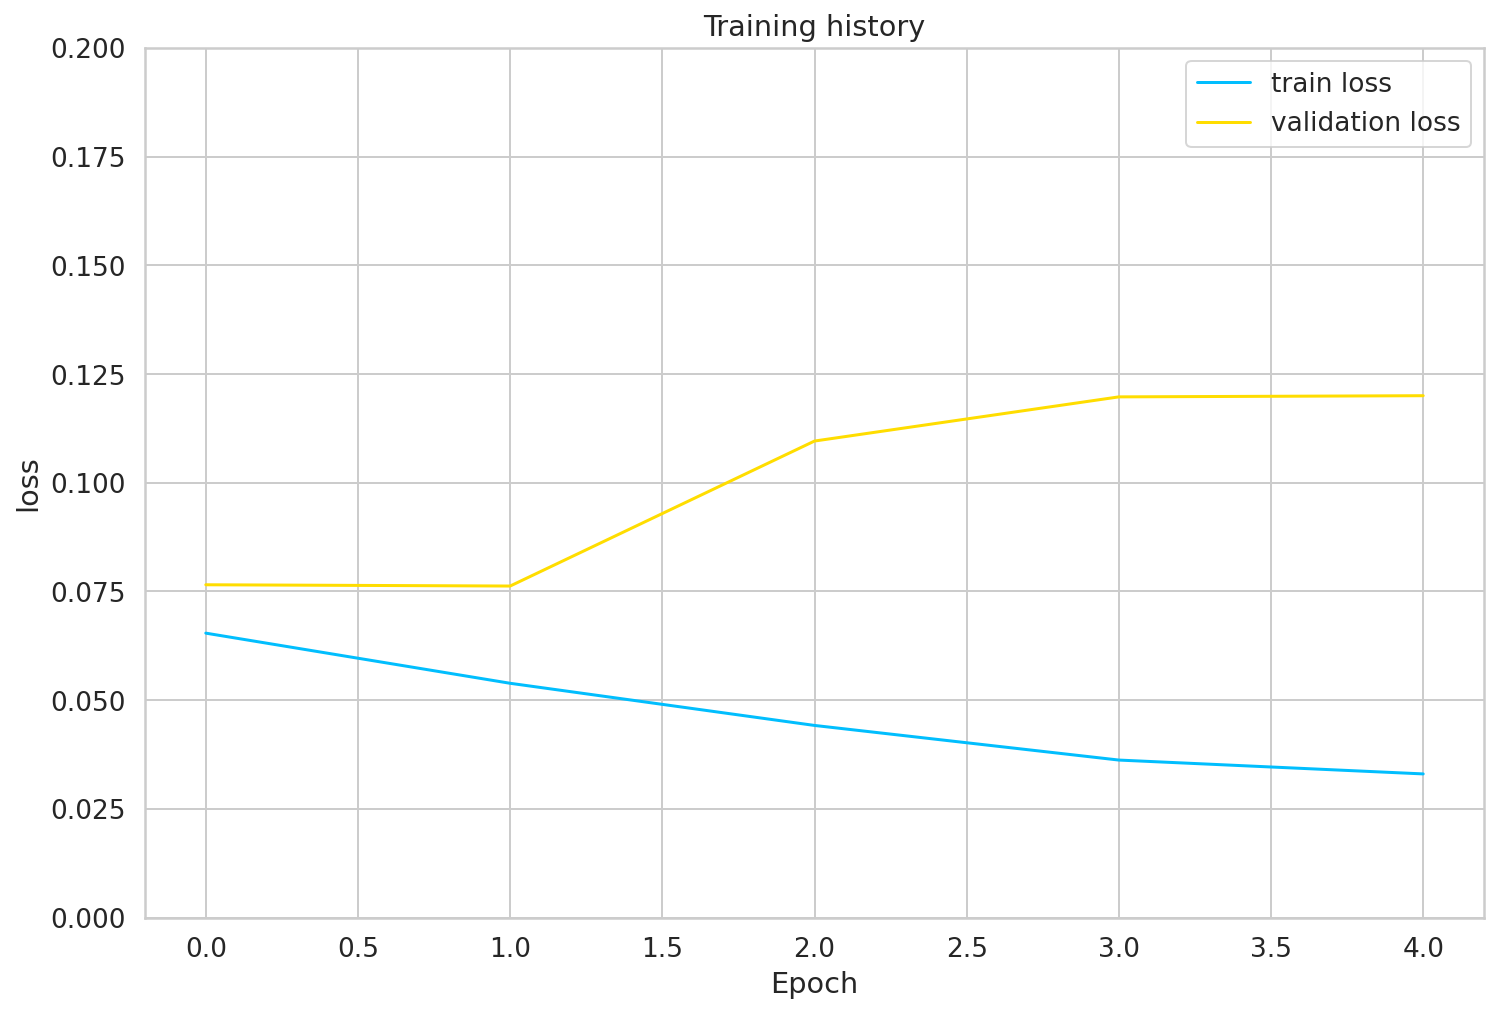

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.2]);

# Sentiment analysis with Character BERT


## download and set the model

In [ ]:
!python character-bert/download.py --model='general_character_bert'

19/04/2021 11:53:21 - INFO - download.py -   Path pretrained-models/general_character_bert already exists.
19/04/2021 11:53:21 - INFO - download.py -   Skipped download of general_character_bert model.


In [ ]:
cd character-bert

/content/drive/My Drive/NLP_PRO_ENSAE/character-bert


In [ ]:
#from modeling.character_bert import CharacterBertModel
from utils.character_cnn import CharacterIndexer
from modeling.character_bert import CharacterBertModel

In [ ]:
def set_model(name='./pretrained-models/general_character_bert/', n_classes=3):
  """"
  name: represent the name of model used on character_bert_model
  n_classes: the number of classes
  """
  config = BertConfig.from_pretrained('bert-base-cased', num_labels=n_classes)
  model = BertForSequenceClassification(config=config)

  #now replace bert with character bert embeddings which was downloaded
  character_bert_model = CharacterBertModel.from_pretrained(name)
  model.bert = character_bert_model
  return model

In [ ]:
## The characterBERT model
model = set_model()
model = model.to(device)

## Data preprocessing

We will keep 30% of train dataset shape because of computationals ressources.

In [ ]:
df_train,_ = train_test_split(df_train, test_size=0.9, stratify=df_train['sentiment'] )
df_test,_ = train_test_split(df_test, test_size=0.9, stratify=df_test['sentiment'] )
df_val,_ = train_test_split(df_val, test_size=0.9, stratify=df_val['sentiment'] )

In [ ]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(30039, 2)
(4940, 11)
(4940, 11)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
characters_indexer = CharacterIndexer()

In [ ]:
X_train = df_train['Text'].tolist()
tokenized_train = [tokenizer.basic_tokenizer.tokenize(text) for text in X_train] #have used basic tokenizer, other tokenizers can also be used
#X_test = df_test['Text'].tolist()
#tokenized_test = [tokenizer.basic_tokenizer.tokenize(text) for text in X_test]
X_val = df_val['Text'].tolist()
tokenized_val = [tokenizer.basic_tokenizer.tokenize(text) for text in X_val]

In [ ]:
tensor_train = characters_indexer.as_padded_tensor(tokenized_train)
#tensor_test = indexer.as_padded_tensor(tokenized_test)
tensor_val = characters_indexer.as_padded_tensor(tokenized_val)

In [ ]:
batch_size = 32

y_train, y_test, y_val = torch.tensor(df_train['sentiment'].values), torch.tensor(df_test['sentiment'].values), torch.tensor(df_val['sentiment'].values)
train_data = TensorDataset(tensor_train, y_train)
train_dataloader = DataLoader(train_data,batch_size=batch_size)

#test_data = TensorDataset(tensor_test, y_test)
#test_dataloader = DataLoader(test_data,batch_size=batch_size)

val_data = TensorDataset(tensor_val, y_val)
val_dataloader = DataLoader(val_data,batch_size=batch_size)

## training

In [ ]:
#this is just to add extra decay and need not be added compulsorily
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

#define loss
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

In [ ]:
def train_char(model, dataloader):
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_labels = batch

    optimizer.zero_grad()
    outputs = model(b_input_ids)[0]
    loss = loss_fn(outputs,b_labels)
    tr_loss += loss.item()
    prediction = torch.argmax(outputs,dim=1)
    correct+=(prediction==b_labels).sum().item()
    nb_tr_examples += b_input_ids.size(0)
    #train_loss_set.append(loss.item())    
    
    loss.backward()

    optimizer.step()
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1


    prediction = torch.argmax(outputs,dim=1)
      preds.append(prediction)
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()
      nb_tr_steps += 1
    test_loss_set1.append(test_loss/nb_tr_steps)
    acc = (correct / total) * 100
    acc1.append(acc)
  

In [ ]:
epochs = 15
train_loss_set1 = []
test_loss_set1 = []
train_loss_set = []
acc1 = []

for epoch in range(epochs):
  print(f'Epoch: {epoch}')
  start_time = time.time()
  model_gen_char_bert.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_labels = batch

    optimizer.zero_grad()
    outputs = model_gen_char_bert(b_input_ids)[0]
    loss = loss_fn(outputs,b_labels)
    #train_loss_set.append(loss.item())    
    
    loss.backward()

    optimizer.step()
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  end_time = time.time()
  train_loss_set1.append(tr_loss/nb_tr_steps)
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  print('Evaluating..')
  preds = []
  nb_tr_steps = 0
  with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0
    for i, batch in enumerate(test_dataloader):
      batch = tuple(t.to(device) for t in batch)

      b_input_ids, b_labels = batch
      
      outputs = model_gen_char_bert(b_input_ids)[0]
      # print (outputs)
      loss = loss_fn(outputs,b_labels)
      test_loss += loss.item()
      prediction = torch.argmax(outputs,dim=1)
      preds.append(prediction)
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()
      nb_tr_steps += 1
    test_loss_set1.append(test_loss/nb_tr_steps)
    acc = (correct / total) * 100
    acc1.append(acc)
    print(f'Test Accuracy: [{correct}]/[{total}] :  {str(acc)[:5]}')
    print('\n')

# Evaluation

In [105]:
## Load model
model = sentiment_analysis(n_classes)
model.load_state_dict(torch.load('best_model_state1.bin'))
model = model.to(device)

NameError: ignored

In [106]:
##accuracy on test set
test_acc, _ = eval(
  model,
  test_data_loader,
  len(df_test),
)

test_acc.item()

TypeError: ignored

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# FInBurt

## load and set model

In [94]:
#!pip install bertModel

In [95]:
from bertModel import BertClassification, dense_opt

In [96]:
labels = {0:'neutral', 1:'positive',2:'negative'}
num_labels= len(labels)
vocab = "finance-uncased"
#vocab_path = "/home/root/new_bert_vocab_uncased_8000"
vocab_path = 'analyst_tone/vocab'
pretrained_weights_path = "analyst_tone/pretrained_weights" # this is pre-trained FinBERT weights
fine_tuned_weight_path = "analyst_tone/fine_tuned.pth"      # this is fine-tuned FinBERT weights
max_seq_length=200

In [100]:
model = BertClassification(weight_path= pretrained_weights_path, num_labels=num_labels, vocab=vocab)
model.load_state_dict(torch.load(fine_tuned_weight_path, map_location = torch.device('cuda:0')))
model = model.to(device)

/content/drive/.shortcut-targets-by-id/1IqM7cDbYq5buCZ4NGtd30LjG6kK7AEx7/NLP_PRO_ENSAE/bertModel.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.classifier.weight)


## load batch

In [101]:
##read data
df_train = pd.read_csv('df_train.csv',index_col=0)
df_test = pd.read_csv('df_test.csv')
df_val = pd.read_csv('df_val.csv')

In [102]:
BATCH_SIZE = 32

train_data_loader = load_batch2(df_train)
#val_data = df_val[['sentiment','Text']]
val_data_loader = load_batch2(df_val)
#test_data = df_test[['sentiment','Text']]
test_data_loader = load_batch2(df_test)

## training

In [103]:
# We set the number of epochs, the optimzer, the loss and the scheduler
class_weights = torch.tensor([np.sum(df_train['sentiment']==0)/len(df_train), np.sum(df_train['sentiment']==1)/len(df_train), np.sum(df_train['sentiment']==2)/len(df_train)])
EPOCHS = 5
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters() , lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.float()).to(device)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'epoch{epoch + 1}/{EPOCHS}')
  print('-'*20)

  train_acc, train_loss = train_ro(model)
  print(f'train accuracy {train_acc} train loss {train_loss}')

  val_acc, val_loss = eval_ro(model) 
  print(f'validation accuracy {val_acc} validation loss {val_loss}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_fin.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.2]);